In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
fig_dir = 'figures/'
import sys
sys.path.append(module_path)
import time
import datetime
import importlib
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport plotting
# %aimport pso
%aimport pso_parallel_training_queue
from data_processing import *
from plotting import *
# from pso import *
from pso_parallel_training_queue import *

np.random.seed(999)
random.seed(999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
### General parameters
total_set_size = 2.9e4 # how many examples will be used for training+validation+testing
train_size = 2e4
val_size = .5e4
test_size = .4e4
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']#, 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0]#,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False # if using the smf in the objective function, must be false!
outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

reinforcement_learning = True
real_observations = False

verbatim = True

network_name = 'testing2'
# network_name = '{}'.format(datetime.datetime.now().strftime("%Y-%m-%d"))
save_all_nets = True

### Network parameters
nr_hidden_layers = 6
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
nr_neurons_per_layer = 6
regularisation_strength = 1e-2
std_penalty = False
norm = {'input': 'zero_mean_unit_std',
        'output': 'zero_mean_unit_std'} # 'none',   'zero_mean_unit_std',   'zero_to_one'

### PSO parameters
nr_processes = 30
nr_iterations = 1000
min_std_tol = 0.01                # minimum allowed std for any parameter
pso_param_dict = {
    'nr_particles': 3 * nr_processes,
    'inertia_weight_start': 1.4,
    'inertia_weight_min': 0.3,
    'exploration_iters': 100,
    'patience': 10000,
    'patience_parameter': 'train',
    'restart_check_interval': 200
}

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Load and preprocess the data

In [29]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts, weigh_by_redshift, outputs_to_weigh,
                                       int(total_set_size), train_size=int(train_size), val_size=int(val_size), test_size=int(test_size), pso=True)
training_data_dict = normalise_data(training_data_dict, norm, pso=True)

# Create a new network

In [30]:
network = Feed_Forward_Neural_Network(nr_hidden_layers, nr_neurons_per_layer, input_features, output_features, 
                                      activation_function, output_activation, regularisation_strength, network_name)
network.setup_pso(pso_param_dict, reinf_learning=reinforcement_learning, real_observations=real_observations, nr_processes=nr_processes)
start = time.time()
network.train_pso(nr_iterations, training_data_dict, std_penalty=std_penalty, verbatim=verbatim, save_all_networks=save_all_nets)
end = time.time()

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


16:11:25  Iteration    0, particle  0, new swarm best. Train: 3.215e+02, Val: 2.965e+02
16:11:26  Iteration    0, particle 11, new swarm best. Train: 2.065e+02, Val: 2.385e+02
16:11:26  Iteration    0, particle 13, new swarm best. Train: 1.432e+02, Val: 1.989e+02
16:11:27  Iteration    0, particle 20, new swarm best. Train: 9.754e+01, Val: 1.673e+02
16:11:27  Iteration    0, particle 28, new swarm best. Train: 7.108e+01, Val: 7.005e+01
16:11:27  Iteration    0, particle 74, new swarm best. Train: 3.855e+01, Val: 8.750e+01
16:11:35  Iteration    3, particle 21, new swarm best. Train: 3.195e+01, Val: 5.558e+01
16:11:35  Iteration    3, particle 85, new swarm best. Train: 2.694e+01, Val: 3.408e+01
16:11:38  Iteration    4, particle  9, new swarm best. Train: 1.912e+01, Val: 3.063e+01
16:11:39  Iteration    4, particle 55, new swarm best. Train: 1.742e+01, Val: 2.191e+01
16:11:39  Iteration    4, particle 58, new swarm best. Train: 1.716e+01, Val: 3.400e+01
16:11:39  Iteration    4, partic

#### Set plot variables

In [32]:
### Standard plots
from keras.models import load_model

dir_name = 'testing2'
iteration = '54'

mode = 'val' # 'train', 'val, 'test'
plot_full_range = True

model = load_model('trained_networks/{}/iter_{}.h5'.format(dir_name, iteration))
training_data_dict = pickle.load(open('trained_networks/{}/training_data_dict.h5'.format(dir_name), 'rb'))

predicted_points = predict_points(model, training_data_dict, mode = mode, original_units=False)
title = 'Inputs: {}\n{:.1e} train points, {}'.format(', '.join(input_features), train_size, mode)

#### Get reinforcement learning plots

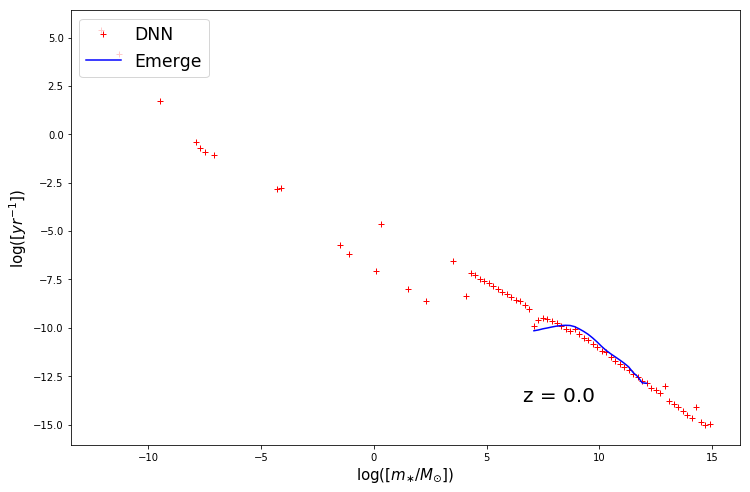

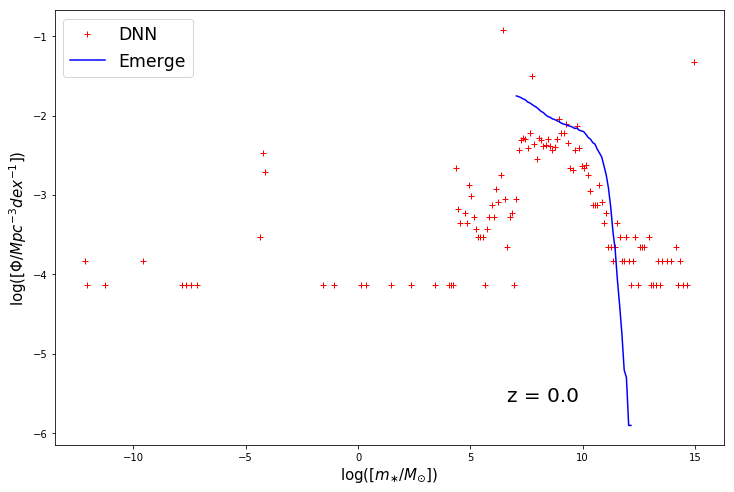

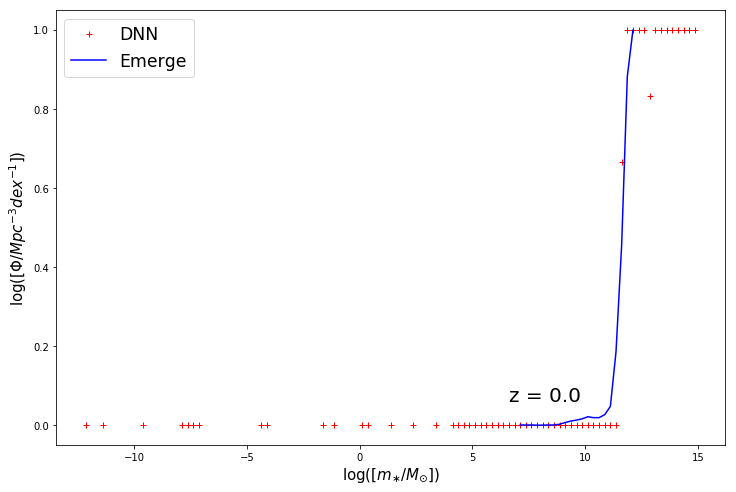

In [33]:
fig73 = get_ssfr_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=mode, full_range=plot_full_range)
fig55 = get_smf_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=mode, full_range=plot_full_range)
fig33 = get_fq_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=mode, full_range=plot_full_range)

In [ ]:
fig73.savefig(fig_dir + 'ssfr_plot_with_smf+ssfr_loss_func_6x6_1k_iters_Z00.png', bbox_inches = 'tight')
fig55.savefig(fig_dir + 'smf_plot_with_smf+ssfr_loss_func_6x6_1k_iters_Z00.png', bbox_inches = 'tight')
fig33.savefig(fig_dir + 'fq_plot_with_smf+ssfr_loss_func_6x6_1k_iters_Z00.png', bbox_inches = 'tight')

#### Get standard pictures

In [ ]:
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'Stellar_mass', pso=True, title=title, data_type=mode,
                                   predicted_points = predicted_points, galaxies=galaxies)

fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)

In [ ]:
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, unit_dict, no_true_plots=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)

fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, unit_dict, no_true_plots=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)

In [ ]:
os.path.dirname('hej/hej.txt')

In [ ]:
fig3.savefig(fig_dir + 'halo_stellar_mass_plot_with_smf+ssfr_loss_func_6x6_1k_iters_Z00.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + 'stellar_mass_sfr_plot_with_smf+ssfr_loss_func_6x6_1k_iters_Z00.png', bbox_inches = 'tight')

In [ ]:
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', pso=True, title=title, data_type=mode, marker_size=20, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
# fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
#                                  y_axis_feature = 'SFR', pso=True, title=title, data_type=mode, marker_size=20,
#                                  y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig6.savefig(fig_dir + 'proof_of_concept_3x3_net_one_output_no_weighing.png', bbox_inches = 'tight')

##### Create progress figures

In [ ]:
model_dir = 'trained_networks/testing2/'
figure_directory =

fig_list = []
for file in os.listdir(model_dir):
    fig_list.append(file)

### Non parallel PSO

In [ ]:
mode = 'train'
network.pso_swarm.set_best_weights('train')
norm_score = network.pso_swarm.evaluate_model(mode)
tot_score = norm_score
model = network.model
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)

fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, mode=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, mode=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, mode=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, mode=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = None, x_max = None, mode=mode)

plt.show